In [1]:
import sys
sys.path.append("..")   # add the root project folder to the system path variable
from schuberts_leader.core_components import simulate_leading_indicator_data, leading_indicator_miner
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint

Simulate some data for us to use:

(documentation is available by running `help(simulate_leading_indicator_data)` in a python REPL)

In [2]:
sim_explain_dict, y_arr, X_arr = simulate_leading_indicator_data(
        n_time_points = 1_000
    ,   n_predictors = 200
    ,   n_leading_indicators = 50
    ,   lagged_effect_time_min_max = (1,20)
    ,   n_y_breakpoints = 8
    ,   y_sim_method = "independent_gaussian" #"gaussian_random_walk"
    ,   noise_std_dev = 0.0
)
X_varnames = [f"X_{i}" for i in range(X_arr.shape[1])]

Have a look at 3 random leading indicators and 5 random non-leading indicators:

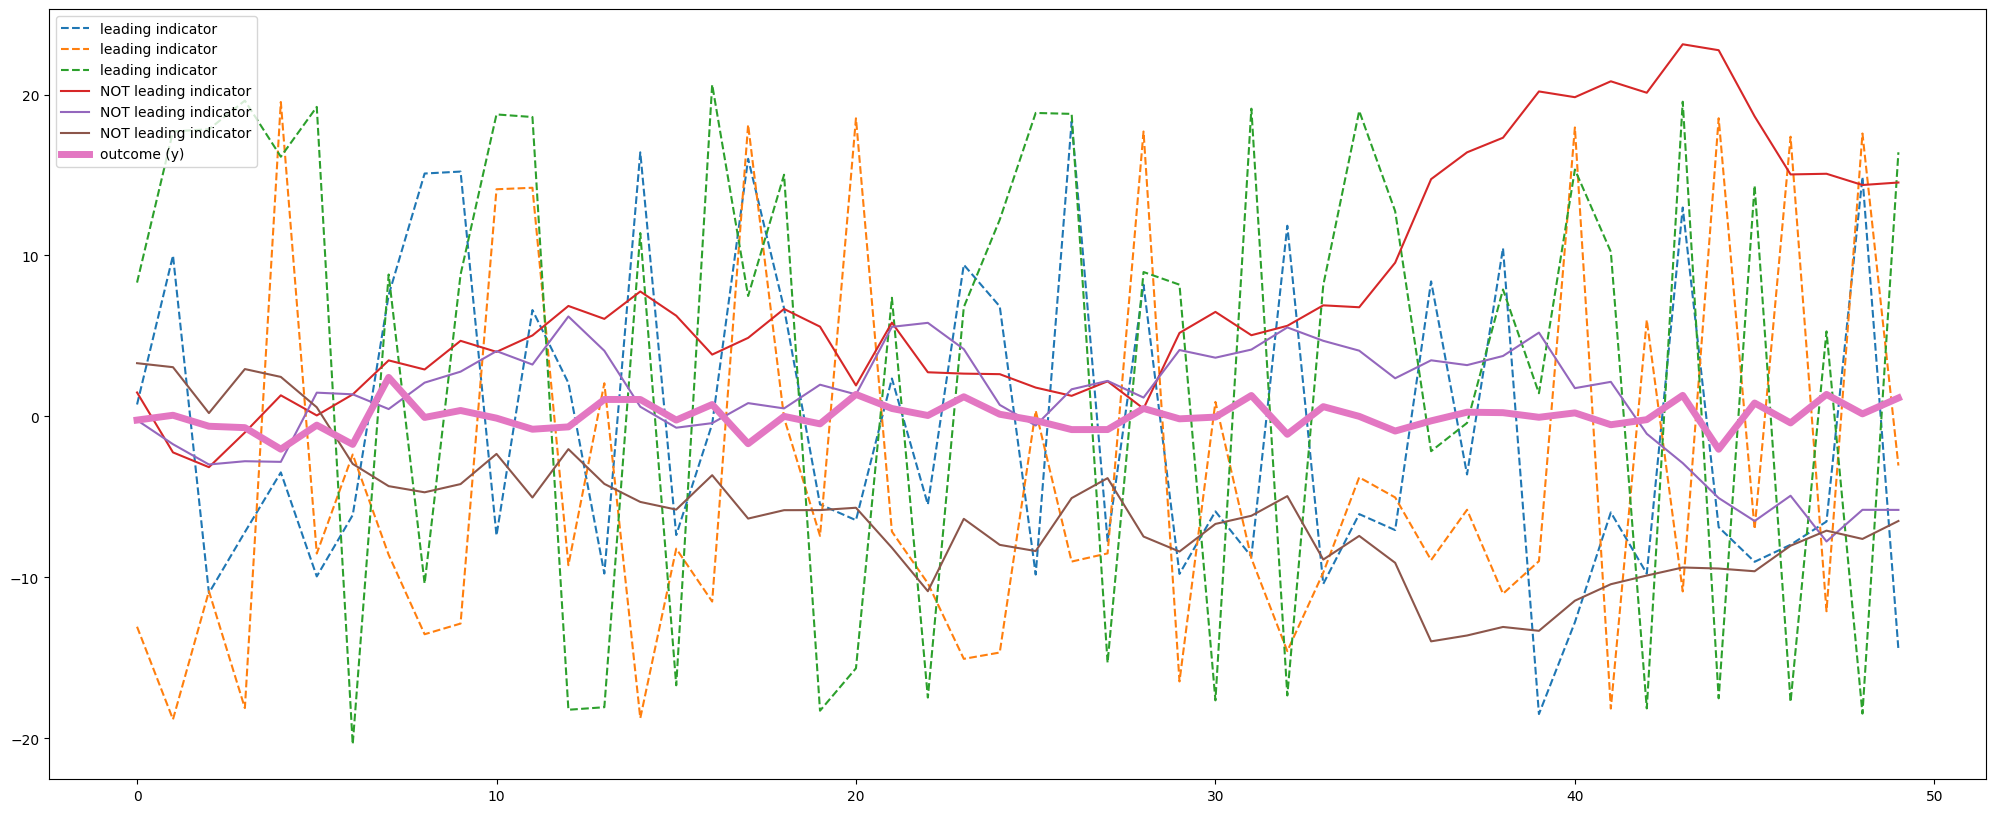

In [3]:
random_leading_ind_idx = np.random.choice( list(sim_explain_dict.keys()), size=3, replace=False)
random_non_leading_ind_idx = np.random.choice( [x for x in range(len(X_varnames)) if x not in list(sim_explain_dict.keys())], size=3, replace=False)
plt.figure( figsize=(25,10) )
for i in random_leading_ind_idx:
    plt.plot(X_arr[:50,i], label="leading indicator", linestyle="--")
for i in random_non_leading_ind_idx:
    plt.plot(X_arr[:50,i], label="NOT leading indicator")
plt.plot(y_arr[:50], label="outcome (y)", linewidth=5)
plt.legend()


Have a look at a (random) few of the simulated leading relationships:

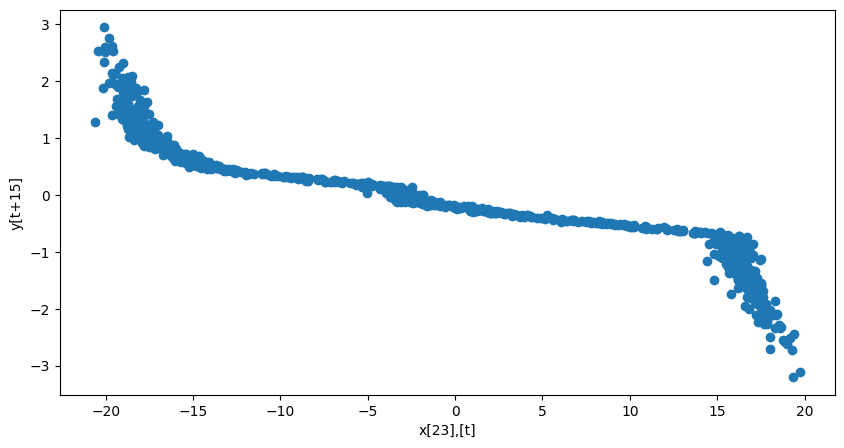

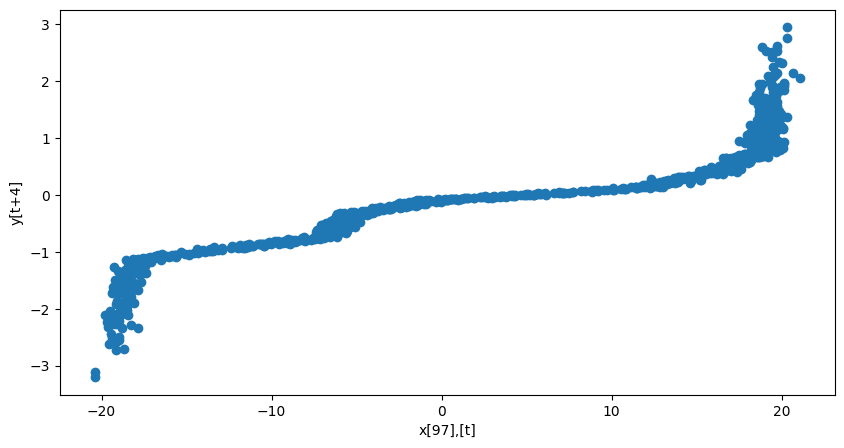

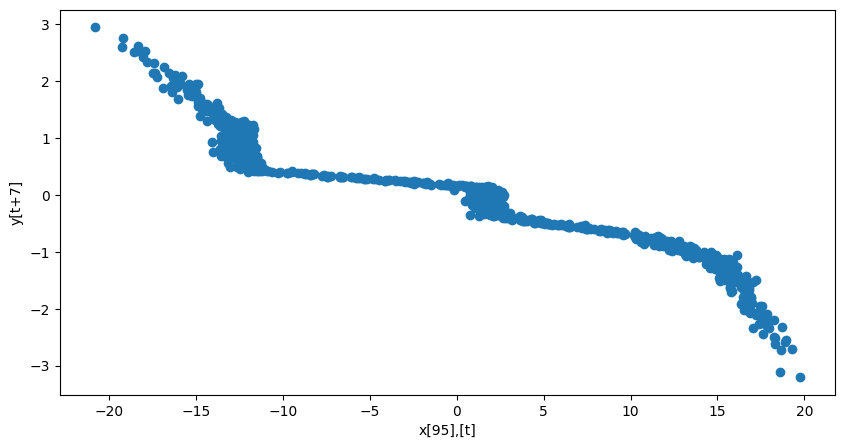

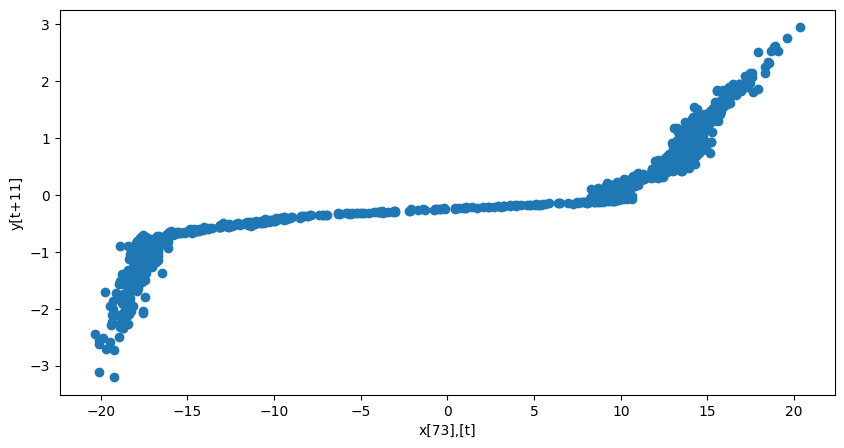

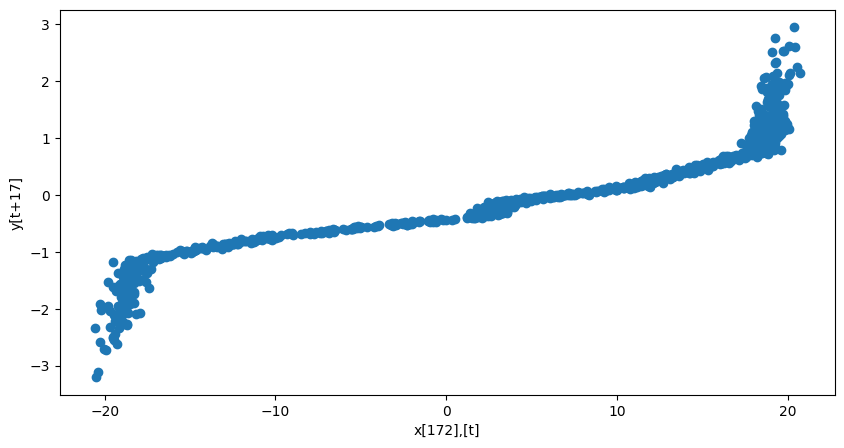

In [4]:
for k in np.random.choice(list(sim_explain_dict.keys()), size=5, replace=False):
    lag_i = sim_explain_dict[k]["relationship_lag"]
    plt.figure( figsize=(10,5) )
    plt.scatter( X_arr[:(len(X_arr)-lag_i),k], y_arr[lag_i:] )
    plt.xlabel( f"x[{k}],[t]" )
    plt.ylabel( f"y[t+{lag_i}]" )

split the data into a training and a test partition:

In [8]:
test_percent = 0.1
train_idx = ( 0, int((1-test_percent)*len(y_arr))-1 ) 
test_idx = (train_idx[1]+1, len(y_arr))
train_y_arr = y_arr[train_idx[0]:train_idx[1]+1] 
test_y_arr = y_arr[test_idx[0]:test_idx[1]] 
train_X_arr = X_arr[train_idx[0]:train_idx[1]+1,:] 
test_X_arr = X_arr[test_idx[0]:test_idx[1],:]

mine the data for training data for leading indicators:

In [9]:
leading_indicator_miner_model = leading_indicator_miner(n_leading_indicators=20)
leading_indicator_miner_model.fit(
    X = train_X_arr, 
    X_varnames = X_varnames, 
    y = train_y_arr, 
    y_varname = "y", 
    n_iterations = 1_000, 
    lags_to_consider = list( range(1,21) ),
    n_knots = 50,
    knot_strategy = "quantiles" #"evenly_spaced"
)

iteration 1,000 of 1,000. best MSE: 0.000

Text(0.5, 1.0, 'Best Mean Squared Error on Training Data')

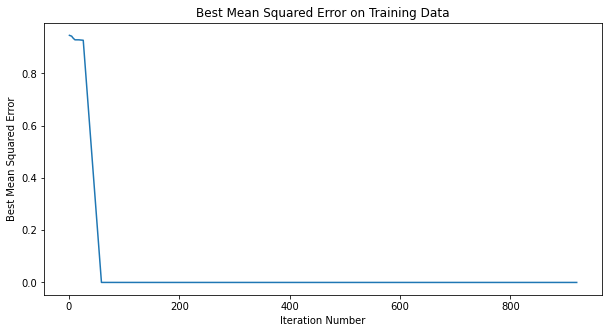

In [10]:
plt.figure( figsize=(10,5) )
plt.plot( 
    [x[0] for x in leading_indicator_miner_model.mse_history],
    [x[1] for x in leading_indicator_miner_model.mse_history],
)
plt.xlabel("Iteration Number")
plt.ylabel("Best Mean Squared Error")
plt.title("Best Mean Squared Error on Training Data")

Text(0.5, 1.0, 'Performance of Each Leading Indicator on In-Sample (Training) Data: Mean Squared Error')

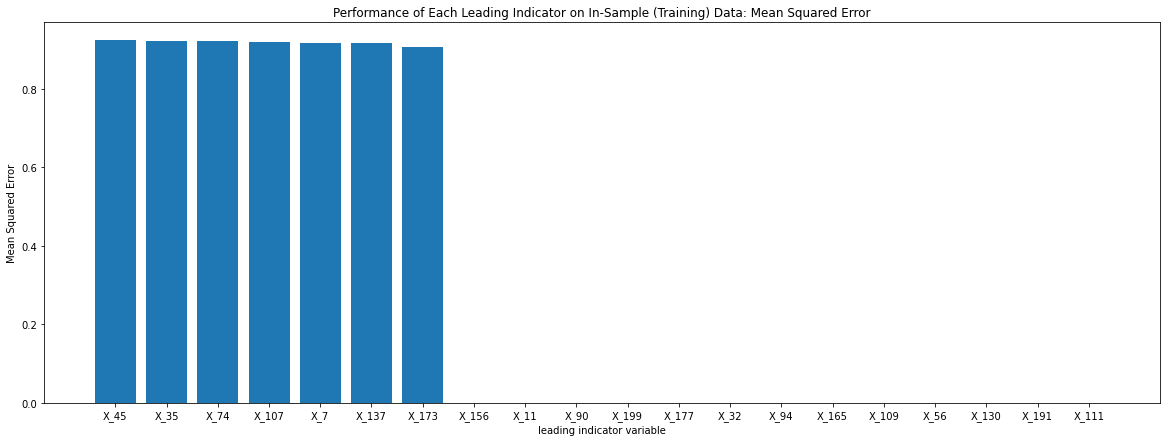

In [11]:
plt.figure( figsize=(20,7) )
plt.bar(
        x = [l["leading_indicator_varname"] for l in leading_indicator_miner_model.best_leading_indicators_vars_set]
    ,   height = [l["mean_squared_error"] for l in leading_indicator_miner_model.best_leading_indicators_vars_set]
) 
plt.xlabel("leading indicator variable")
plt.ylabel("Mean Squared Error")
plt.title("Performance of Each Leading Indicator on In-Sample (Training) Data: Mean Squared Error")

only keep the top 10 best leading indicators:

In [12]:
leading_indicator_miner_model.best_leading_indicators_vars_set = leading_indicator_miner_model.best_leading_indicators_vars_set[-10:]
leading_indicator_miner_model.n_leading_indicators = len(leading_indicator_miner_model.best_leading_indicators_vars_set)

visualize the leading indicators discovered:

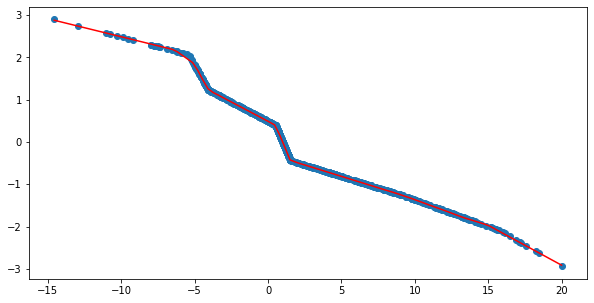

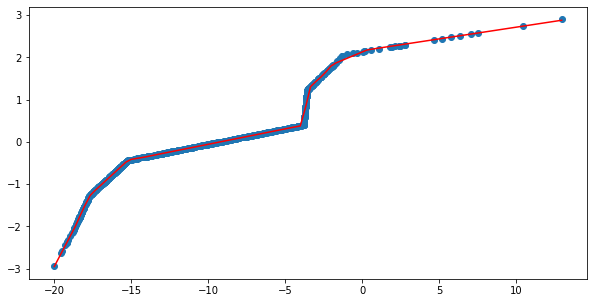

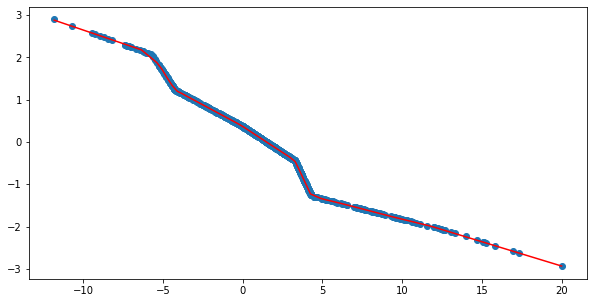

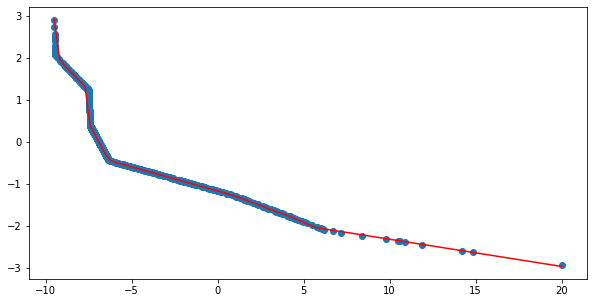

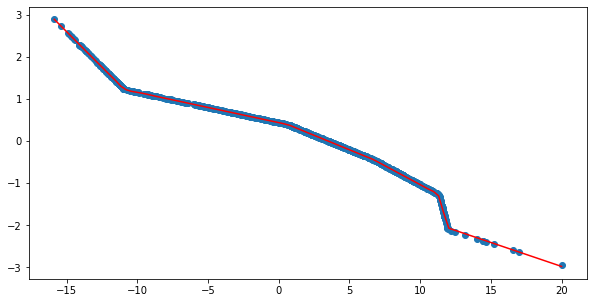

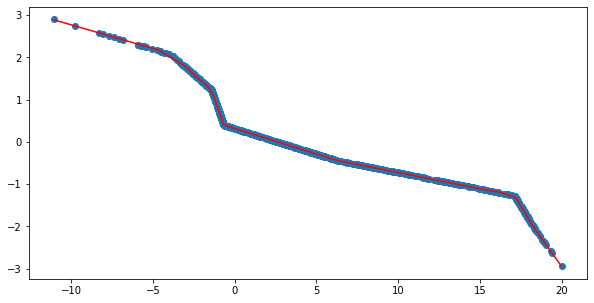

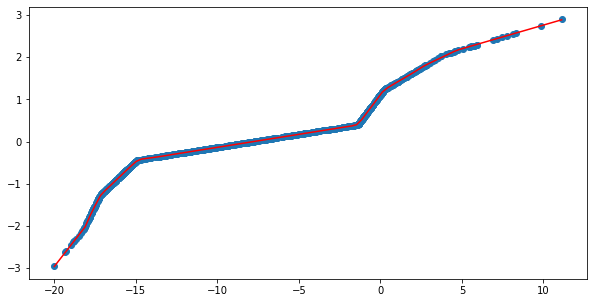

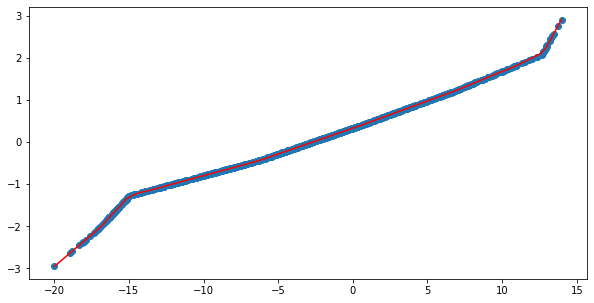

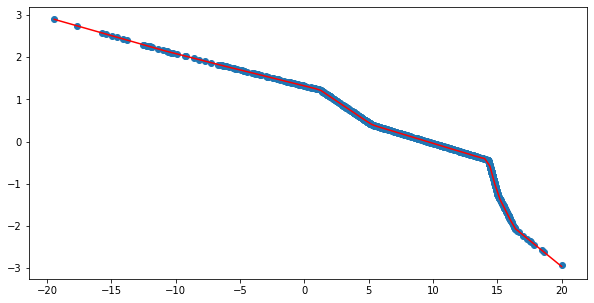

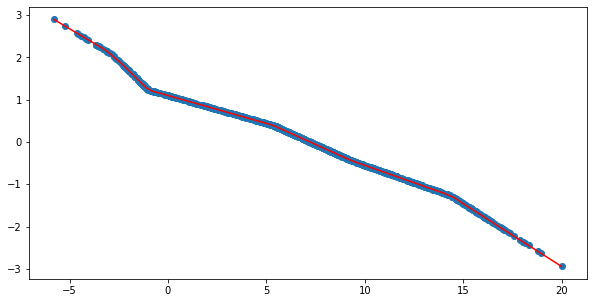

In [13]:
for x in leading_indicator_miner_model.best_leading_indicators_vars_set:
    lag_i = x["lag_n_time_periods"]
    x_vec = train_X_arr[:(len(train_X_arr)-lag_i),X_varnames.index(x["leading_indicator_varname"])]
    y_vec = train_y_arr[lag_i:]
    pred_illus_range = np.linspace(start=x_vec.min(), stop=x_vec.max(), num=100)
    pred_illus_spline_vars = leading_indicator_miner_model.create_linear_splines(X_vec=pred_illus_range, knot_points_list=x["knot_locations"])
    pred_illus_x_matrix = np.column_stack(
                    [np.ones_like(pred_illus_range), pred_illus_range, pred_illus_spline_vars]
                )
    pred_illus_y = leading_indicator_miner_model.generate_linear_model_preds(
                X_matrix=pred_illus_x_matrix,
                beta_coefs_vec=x["beta_coefs"],
            )
    plt.figure( figsize=(10,5) )
    plt.scatter(x_vec, y_vec)
    plt.plot(pred_illus_range, pred_illus_y, color="red")

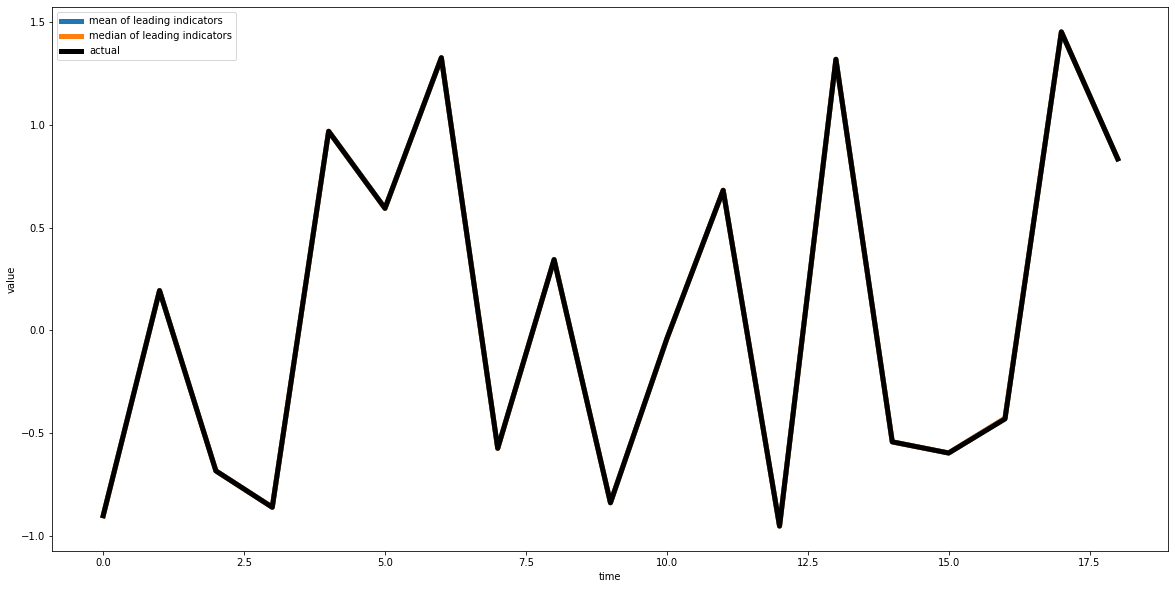

In [14]:
test_forecasts = leading_indicator_miner_model.predict(
    X = train_X_arr, 
    X_varnames = X_varnames
)
mean_test_forecast = np.nanmean(test_forecasts, axis=1)
median_test_forecast = np.nanmedian(test_forecasts, axis=1)
max_forecast_length = test_forecasts.shape[0]
plt.figure( figsize=(20,10) )
for i in range(test_forecasts.shape[1]):
    plt.plot(test_forecasts[:,i], color="grey")
plt.plot( mean_test_forecast, linewidth=5, label="mean of leading indicators" )
plt.plot( median_test_forecast, linewidth=5, label="median of leading indicators" )
plt.plot( test_y_arr[:max_forecast_length], linewidth=5, label="actual", color="black" )
plt.xlabel("time")
plt.ylabel("value")
plt.legend()